## Run Parameter Sweep for Alpha Vals

Need to re-run the parameter sweep to get optimal alpha for each situation. Want to optimize to ENTROPY.

Then perhaps optimize gamma based on the optimal alpha values. Gamma should be based on the RS and RP decision type vectors.

Store info in a data frame for easy use later.

In [1]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random
from collections import defaultdict
import copy
import matplotlib.colors as c
from matplotlib.cm import hsv
plt.rcParams['axes.axisbelow'] = True

In [5]:
%run ./SimulationCode.ipynb # contains the functions that run the simulations
%run ./ComputedVals.ipynb # contains some computations based on the dataframes, did not want to clutter the file.

Exception: File `'././SimulationCode.ipynb'` not found.

In [ ]:
network_sizes = {'20': (20, normalize20), '50': (50, normalize50)} #, '100':(100, normalize100)}
proportions = {'homogeneously_mixing_hashtag': hh_proportions, 'homogeneously_mixing_face': fh_proportions,
               'spatially_embedded_hashtag': hs_proportions, 'spatially_embedded_face': fs_proportions}
normalized_entropies = {'homogeneously_mixing_hashtag': hh_avg_normalized, 'homogeneously_mixing_face': hf_avg_normalized,
                        'spatially_embedded_hashtag': sh_avg_normalized, 'spatially_embedded_face': sf_avg_normalized}

In [3]:
from matplotlib.legend_handler import HandlerTuple

In [157]:
def create_plot(dataframes, optimizers, indep, plot_params, filename):
    fig = plt.figure(figsize=(10, 8))
    plt.grid(zorder=-10)
    
    plt.ylim(0.15, 1.05)
    x_values = dataframes['Homogeneously Mixing, Face Prior'][indep].to_numpy()
    
    facedata = {indep: x_values}
    hashtagdata = {indep: x_values}
    
    for exp_type in dataframes.keys():
        #for o in optimizers:
        #display(dataframes[exp_type].index)
        
        dataframes[exp_type]['PlotAvg'] = np.mean([dataframes[exp_type][optim].to_numpy() for optim in optimizers], axis=0)
        normalized = dataframes[exp_type]['PlotAvg']/(dataframes[exp_type]['PlotAvg'].max())
        
        #dataframes[exp_type]['PlotAvgNormalized'] = normalized
        
        #avg = dataframes[exp_type]['PlotAvgNormalized']
        
        if 'Face' in exp_type:
            facedata[exp_type] = normalized
        else:
            hashtagdata[exp_type] = normalized
        
    facedf = pd.DataFrame(facedata)
    hashtagdf = pd.DataFrame(hashtagdata)
    
    ## plot one at a time to get legend
    homo_face = plt.scatter(x_values, facedata['Homogeneously Mixing, Face Prior'], color = 'xkcd:powder blue', marker='^', s=10)
    spat_face = plt.scatter(x_values, facedata['Spatially Embedded, Face Prior'], color = 'xkcd:powder blue', marker='v', s=10)
    
    homo_hashtag = plt.scatter(x_values, hashtagdata['Homogeneously Mixing, Hashtag Prior'], color = 'xkcd:baby pink', marker='^', s=10)
    spat_hashtag = plt.scatter(x_values, hashtagdata['Spatially Embedded, Hashtag Prior'], color = 'xkcd:baby pink', marker='v', s=10)
    
    facedf['Average'] = np.mean([facedf[col] for col in facedf.columns if col != indep], axis=0)
    hashtagdf['Average'] = np.mean([hashtagdf[col] for col in hashtagdf.columns if col != indep], axis=0)
        
    normalizedface_avg = facedf['Average'].to_numpy()/max(facedf['Average'])
    facedf['Normalized Average'] = normalizedface_avg
    
    face_avg = plt.scatter(x_values, normalizedface_avg, color='xkcd:cobalt', marker='.')
    face_min = plt.scatter(facedf.iloc[facedf['Normalized Average'].idxmin()][indep],
                           facedf['Normalized Average'].min(), marker='o', color='xkcd:cobalt', edgecolors='black', s=50)
    
    plt.vlines(x=facedf.iloc[facedf['Normalized Average'].idxmin()][indep], ymin=0.15, ymax=facedf['Normalized Average'].min(), color='xkcd:cobalt')
    #print(facedf.iloc[facedf['Normalized Average'].idxmin()]['Alpha'])
    #plt.text(facedf.iloc[facedf['Normalized Average'].idxmin()][indep], 0.12, f'{facedf.iloc[facedf["Normalized Average"].idxmin()][indep]:.1f}', color='xkcd:cobalt')
        
    normalizedht_avg = hashtagdf['Average'].to_numpy()/max(hashtagdf['Average'])
    hashtagdf['Normalized Average'] = normalizedht_avg
    
    #print(hashtagdf.iloc[hashtagdf['Normalized Average'].idxmin()][indep])
    
    ht_avg = plt.scatter(x_values, normalizedht_avg, color='xkcd:deep pink', marker='.')
    
    ht_min = plt.scatter(hashtagdf.iloc[hashtagdf['Normalized Average'].idxmin()][indep], 
                         hashtagdf['Normalized Average'].min(), marker='o', color='xkcd:deep pink', edgecolors='black', s=50)
    
    plt.vlines(x=hashtagdf.iloc[hashtagdf['Normalized Average'].idxmin()][indep], ymin=0.15, ymax=hashtagdf['Normalized Average'].min(), color='xkcd:deep pink')
    #print(hashtagdf.iloc[hashtagdf['Normalized Average'].idxmin()][indep])
    
    #plt.text(hashtagdf.iloc[hashtagdf['Normalized Average'].idxmin()][indep], 0.12, f'{hashtagdf.iloc[hashtagdf["Normalized Average"].idxmin()][indep]:.1f}', color='xkcd:deep pink')
    

    
    handles1 = [homo_face, spat_face, face_avg, face_min]
    labels1 = ['Homogeneously Mixing', 'Spatially Embedded', 'Average', 'Minimum:'+r' $\alpha =$ '+ f'{facedf.iloc[facedf["Normalized Average"].idxmin()][indep]:.2f}']
    
    handles2 = [homo_hashtag, spat_hashtag, ht_avg, ht_min]
    labels2 = ['Homogeneously Mixing', 'Spatially Embedded', 'Average', 'Minimum:'+r' $\alpha =$ '+ f'{hashtagdf.iloc[hashtagdf["Normalized Average"].idxmin()][indep]:.2f}']
    
    plt.xticks(plot_params['xticks'])
    plt.yticks(plot_params['yticks'])
    plt.xlabel(plot_params['xlabel'], fontsize=12)
        
    plt.ylabel(plot_params['ylabel'], fontsize=12)
    plt.title(plot_params['title'], fontsize=14)
    
    l = plt.legend(handles1, labels1,
               handler_map={tuple: HandlerTuple(ndivide=None)}, loc ='upper center', bbox_to_anchor=(0.4, 1), title='Face/Name Prior', title_fontproperties={'weight':'bold'})#, #bbox_to_anchor=(2, 0.52))
    l2 = plt.legend(handles2, labels2,
               handler_map={tuple: HandlerTuple(ndivide=None)}, loc='lower center', bbox_to_anchor=(0.8, 0.51), title='Hashtag Prior',title_fontproperties={'weight':'bold'})
    fig.add_artist(l)
    fig.add_artist(l2)
        
    #plt.legend()
    plt.savefig(filename)

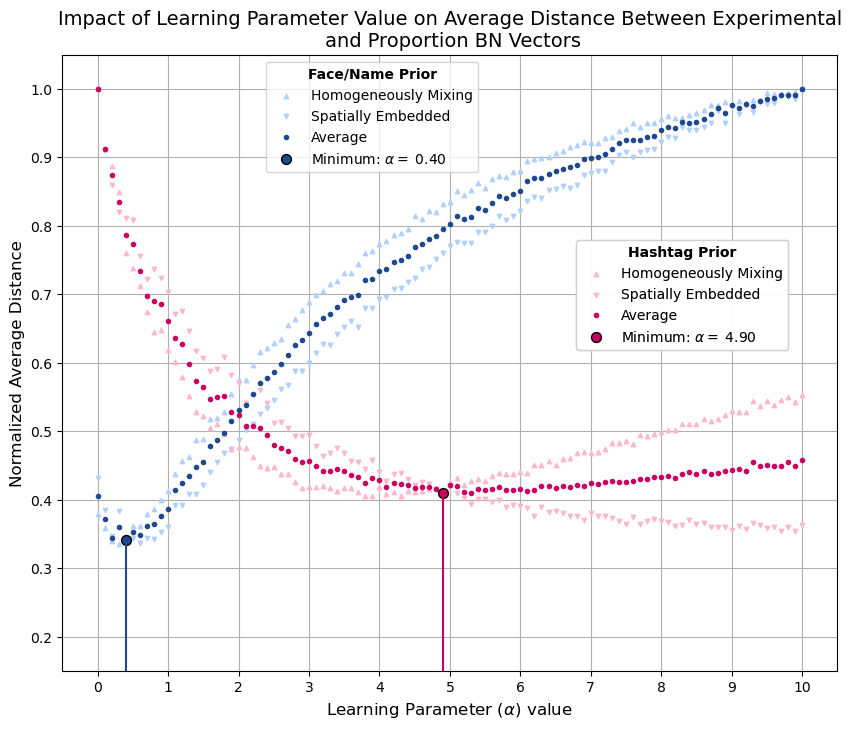

In [158]:
homo_face = pd.read_csv('Alpha Optimization/homo_face_alpha500.csv')
homo_hashtag = pd.read_csv('Alpha Optimization/homo_hashtag_alpha500.csv')
spatial_face = pd.read_csv('Alpha Optimization/spat_face_alpha500.csv')
spatial_hashtag = pd.read_csv('Alpha Optimization/spat_hashtag_alpha500.csv')

dataframes=[homo_face, spatial_face, homo_hashtag, spatial_hashtag]

dataframes = {'Homogeneously Mixing, Face Prior': homo_face, 'Spatially Embedded, Face Prior': spatial_face,
               'Homogeneously Mixing, Hashtag Prior': homo_hashtag, 'Spatially Embedded, Hashtag Prior': spatial_hashtag}

optimizers = ['entropy_dist']
indep = 'alpha'

plot_params = {'xticks': list(range(0, 11)), 'yticks': [x * 0.1 for x in range(2, 11)],
               'xlabel': r'Learning Parameter ($\alpha$) value','ylabel': 'Normalized Average Distance',
               'title': 'Impact of Learning Parameter Value on Average Distance Between Experimental\n and Simulated Entropy'}


create_plot(dataframes, optimizers, indep, plot_params, 'Alpha Optimization/AlphaOptimization.png')

**The code below here was used to create the dataframes that produced the plots. For each case I ran 500 simulations fo reach alpha value with gamma=1 and averaged the distances for each category. To produce the plots I only used the *entropy distance*, none of the other data.**

#### **There is no need to run this code again, it is just for reference. The lines that take a long time are commented out.**

In [ ]:
def run_alpha_sweep(alpha_vals, network_type, response_type, prior, num_rounds, filename, num_trials):
    gamma = 1
    
    data = {'alpha':[], 'entropy_dist':[], 'bn_dist':[], 'ec_dist':[], 'rs_dist':[], 'rp_dist':[]}
    dt_proportions = proportions[network_type + '_' + response_type]
    experimental_avg_entropy = normalized_entropies[network_type + '_' + response_type]
    
    for a in alpha_vals:
        print(f'alpha = {a:.1f}', end = '     ')
        entropy_distances = []
        bn_distances = []
        ec_distances =[]
        rs_distances = []
        rp_distances = []
        
        for k in network_sizes.keys():
            n = network_sizes[k][0]
            G, pairs = gen_network(n, network_type, num_rounds)
            
            for _ in range(num_trials):
                newG, finalDF = CAA_simulation(G, pairs, network_type, prior, num_rounds, a, gamma, response_type)
                ent_normalized = np.array(compute_entropy(finalDF))/network_sizes[k][1]
                
                entropy_distance = np.linalg.norm(ent_normalized-experimental_avg_entropy)
                
                entropy_distances.append(entropy_distance)
                
                grouped_trial = finalDF.groupby(['TrialNumber', 'DecisionType']).size().unstack(fill_value=0) # group the data by trial and decision type columns for plotting
                grouped_trial = grouped_trial.loc[:, grouped_trial.sum().sort_values(ascending=False).index] # Sort columns by total count
                
                ## BN distance
                bn_prop = grouped_trial['BN'].to_numpy()/n
                bn_dist = np.linalg.norm(dt_proportions[0] - bn_prop)

                bn_distances.append(bn_dist)

                ## EC distance
                if 'EC' in grouped_trial.columns:
                    ec_prop = grouped_trial['EC'].to_numpy()/n
                    ec_dist = np.linalg.norm(dt_proportions[1] - ec_prop)
                else:
                    #ec_prop = np.zeros(n)
                    ec_dist = np.linalg.norm(dt_proportions[1])

                ec_distances.append(ec_dist)

                ## RS distance
                rs_prop = grouped_trial['RS'].to_numpy()/n
                rs_dist = np.linalg.norm(dt_proportions[2] - rs_prop)

                rs_distances.append(rs_dist)

                ## RP distance
                rp_prop = grouped_trial['RP'].to_numpy()/n
                rp_dist = np.linalg.norm(dt_proportions[3] - rp_prop)

                rp_distances.append(rp_dist)
            
            avg_ent_dist = sum(entropy_distances)/len(entropy_distances)
            avg_bn_dist = sum(bn_distances)/len(bn_distances)
            avg_ec_dist = sum(ec_distances)/len(ec_distances)
            avg_rs_dist = sum(rs_distances)/len(rs_distances)
            avg_rp_dist = sum(rp_distances)/len(rp_distances)
            
        data['entropy_dist'].append(avg_ent_dist)
        data['bn_dist'].append(avg_bn_dist)
        data['ec_dist'].append(avg_ec_dist)
        data['rs_dist'].append(avg_rs_dist)
        data['rp_dist'].append(avg_rp_dist)
        data['alpha'].append(a)
        
    df = pd.DataFrame(data)
    df.to_csv(filename)
        
    return df

In [101]:
alpha_vals = np.linspace(0, 10, 101)
network_type = 'homogeneously_mixing'
response_type = 'hashtag'
prior = htprior
num_rounds = 40
filename = 'homo_hashtag_alpha500.csv'
num_trials = 500
#run_alpha_sweep(alpha_vals, network_type, response_type, prior, num_rounds, filename, num_trials)

In [ ]:
alpha_vals = np.linspace(0, 10, 101)
network_type = 'spatially_embedded'
response_type = 'hashtag'
prior = htprior
num_rounds = 40
filename = 'spat_hashtag_alpha500.csv'
num_trials = 500
#run_alpha_sweep(alpha_vals, network_type, response_type, prior, num_rounds, filename, num_trials)

In [102]:
alpha_vals = np.linspace(0, 10, 101)
network_type = 'homogeneously_mixing'
response_type = 'face'
prior = faceprior
num_rounds = 40
filename = 'homo_face_alpha500.csv'
num_trials = 500
#run_alpha_sweep(alpha_vals, network_type, response_type, prior, num_rounds, filename, num_trials)

In [ ]:
alpha_vals = np.linspace(0, 10, 101)
network_type = 'spatially_embedded'
response_type = 'face'
prior = faceprior
num_rounds = 40
filename = 'spat_face_alpha500.csv'
num_trials = 500
#run_alpha_sweep(alpha_vals, network_type, response_type, prior, num_rounds, filename, num_trials)